In [16]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import MAS_library as pylians_MASL
import smoothing_library as pylians_SL
%matplotlib inline


# Histogram 3d

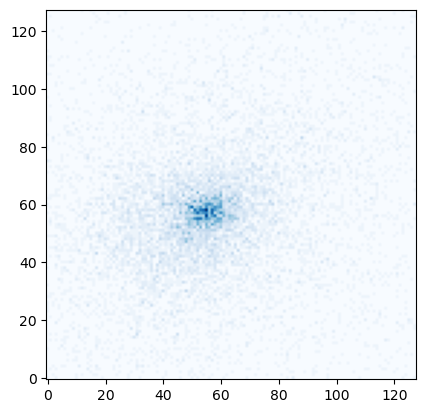

In [31]:
cutout = 'cutout_818916.hdf5'
f =  h5py.File(cutout,'r')

x = f['PartType1']['Coordinates'][:,0]
y = f['PartType1']['Coordinates'][:,1]
z = f['PartType1']['Coordinates'][:,2]

center = np.array([np.mean(x), np.mean(y), np.mean(z)]) # center of the box

x = x - center[0]
y = y - center[1]
z = z - center[2]

max_size = np.max([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])
max_size = max_size/10 # size of the box (???)

grid_size = 128
pos = np.array([x, y, z]).T
hist, bins = np.histogramdd(pos, bins=grid_size, range=[[-max_size/2, max_size/2], [-max_size/2, max_size/2], [-max_size/2, max_size/2]])

plt.imshow(hist.sum(axis=2), origin='lower', cmap='Blues')

In [54]:
#test histogram: find cell with most particles, get it i,j,k and compare with a normal query to the positions

argmax = np.unravel_index(hist.argmax(), hist.shape)
i_test = argmax[0]
j_test = argmax[1]
z_test = argmax[2]

test_xmin, test_xmax = bins[0][i_test],bins[0][i_test+1]
test_ymin, test_ymax = bins[1][j_test],bins[1][j_test+1]
test_zmin, test_zmax = bins[2][z_test],bins[2][z_test+1]

test_hist = hist[i_test, j_test, z_test]

test_count = np.sum( (x > test_xmin) & (x < test_xmax) & (y > test_ymin) & (y < test_ymax) & (z > test_zmin) & (z < test_zmax) )

print(test_hist, test_count)

4.0 4


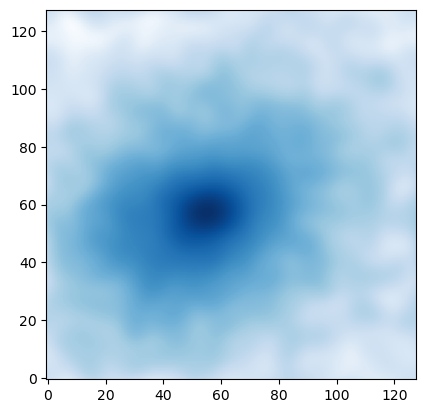

In [69]:

R = 1 #kpc/h
#Filter = 'Top-Hat'
Filter = 'Gaussian'
threads = 28

hist_32 = hist.astype(np.float32)

W_k = pylians_SL.FT_filter(max_size, R, grid_size, Filter, threads)

hist_smoothed_32 = pylians_SL.field_smoothing(hist_32, W_k, threads)

plt.imshow(np.log10(hist_smoothed_32.sum(axis=2)), origin='lower', cmap='Blues')


In [60]:
#let test_xmin, test_ymax, test_zmax be a center. calculate, for each point on the grid, the distance to the center and the number of particles in the cell

distances = np.zeros((grid_size, grid_size, grid_size))

center = np.array([(test_xmin+test_xmax)/2, (test_ymin+test_ymax)/2, (test_zmin+test_zmax)/2])

for i in range(grid_size):
    for j in range(grid_size):
        for k in range(grid_size):
            xmid = (bins[0][i]+bins[0][i+1])/2
            ymid = (bins[1][j]+bins[1][j+1])/2
            zmid = (bins[2][k]+bins[2][k+1])/2
        
            distances[i,j,k] = np.sqrt((xmid-center[0])**2 + (ymid-center[1])**2 + (zmid-center[2])**2)



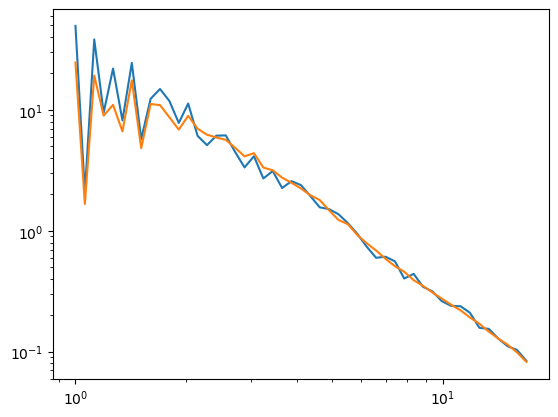

In [70]:
radiuses = np.geomspace(1, max_size/2, 50)

counts = []
counts_smooth = []
volumes = []

for i in range(len(radiuses)-1):
    mask = (distances < radiuses[i+1]) & (distances > radiuses[i])

    counts.append(hist[mask].sum())
    counts_smooth.append(hist_smoothed_32[mask].sum())

    volumes.append(4/3 * np.pi * (radiuses[i+1]**3 - radiuses[i]**3))

counts = np.array(counts)
volumes = np.array(volumes)

plt.figure()
plt.loglog(radiuses[:-1], counts/volumes)
plt.loglog(radiuses[:-1], counts_smooth/volumes)


# Pylians3


Using CIC mass assignment scheme
Time taken = 0.003 seconds

200.68294 37524.01 37478.0 37524


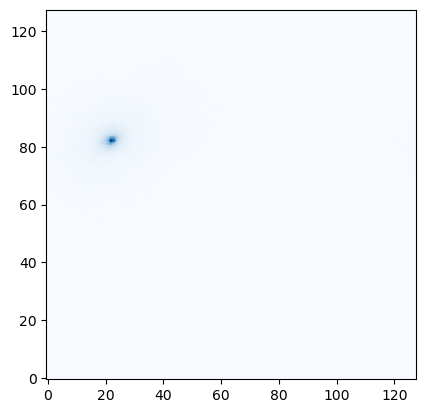

In [4]:
pos_f32 = pos + center #does not work with negative values, so centroid is added back
pos_f32 = pos_f32.astype(np.float32)

counts = np.zeros((grid_size,grid_size,grid_size), dtype=np.float32)
boxsize = np.float32(max_size) #boxsize = max_size (???)

pylians_MASL.MA(pos_f32, counts, boxsize, "CIC", verbose=True)

plt.imshow(counts.sum(axis=2), origin='lower', cmap='Blues')

print(np.max(counts), np.sum(counts), np.sum(hist), len(x))
